# Week 11: Sentiment Analysis, Part 2: Plotting Curves with Rolling Averages

This week, our questions and concepts are robust, but the amount of new code to learn is modest :)

Our focus is on plotting "sentiment curves." We will:
* Plot the raw values for sentiment in *The Sign of the Four*
* Calculate rolling averages, plot them, and investigate the portions of the text at which the minimum and maximum points occur

# Getting back to Sentiment Comparison

In [18]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

df = pd.read_csv('sentiment_test.csv')
df.head()

vader_analyzer = SentimentIntensityAnalyzer()

audit_results = {}
audit_results["Sentence"] = []
audit_results["Category"] = [] #adding Category to our dictionary
audit_results["VADER Sentiment"] = []
audit_results["VADER Score"] = []
audit_results["TextBlob Sentiment"] = []
audit_results["TextBlob Polarity"] = []
audit_results["Difference Detected"] = []

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [19]:
#create two lists from text and category columns
texts = df['text'].tolist()
categories = df['category'].tolist()
#create a dictionary with sentences as keys and categories as values
text_to_category = dict(zip(texts, categories))

texts[0]
text_to_category[texts[0]] #now we can get a category for any text

'sarcasm'

In [51]:
#same code as we used last time, only adding category to the result

for sentence in texts:
    # VADER sentiment
    vader_scores = vader_analyzer.polarity_scores(sentence)
    vader_sentiment = "Positive" if vader_scores['compound'] >= 0.05 else "Negative" if vader_scores['compound'] <= -0.05 else "Neutral"

    # TextBlob sentiment
    blob = TextBlob(sentence)
    blob_polarity = blob.sentiment.polarity
    blob_subjectivity = blob.sentiment.subjectivity
    blob_sentiment = "Positive" if blob_polarity > 0 else "Negative" if blob_polarity < 0 else "Neutral"

    # Detect if there is a difference in sentiment
    difference_detected = vader_sentiment != blob_sentiment

    # Append results to the data dictionary
    audit_results["Sentence"].append(sentence)
    audit_results["Category"].append(text_to_category[sentence])
    audit_results["VADER Sentiment"].append(vader_sentiment)
    audit_results["VADER Score"].append(vader_scores['compound'])
    audit_results["TextBlob Sentiment"].append(blob_sentiment)
    audit_results["TextBlob Polarity"].append(blob_polarity)
    audit_results["Difference Detected"].append(difference_detected)


results_df = pd.DataFrame(audit_results)
results_df.head()

,Sentence,Category,VADER Sentiment,VADER Score,TextBlob Sentiment,TextBlob Polarity,Difference Detected
0,"Oh great, another meeting that could've been a...",sarcasm,Positive,0.6588,Positive,1.0,False
1,Well isn't this just perfect...,sarcasm,Positive,0.2732,Positive,1.0,False
2,How wonderful to spend my Sunday fixing someon...,sarcasm,Positive,0.2960,Positive,1.0,False
3,Thanks for nothing,sarcasm,Positive,0.4404,Positive,0.2,False
4,You're so helpful /s,sarcasm,Positive,0.4754,Neutral,0.0,True


Reminder on calculating mean by group and sorting

In [25]:
results_df.groupby('Category')['VADER Score'].mean()
results_df.groupby('Category')['VADER Score'].mean().sort_values(ascending=False)

,VADER Score
Category,
intensifiers,0.524971
mixed_sentiment,0.487114
sarcasm,0.413857
emoji_slang,0.366071
subtle_implications,0.320900
complex_emotions,0.190600
negations,0.135371
context_dependent,-0.280214


Now let's compare means. Note `[[` to supply multiple columns

In [ ]:
mean_by_category = results_df.groupby('Category')[['VADER Score', 'TextBlob Polarity']].mean()
mean_by_category.round(3)

How about the difference between two systems by category?

In [33]:
mean_by_category['Mean Difference'] = abs(mean_by_category['VADER Score'] - mean_by_category['TextBlob Polarity']).round(3)
mean_by_category = mean_by_category.sort_values('Mean Difference', ascending=False)
mean_by_category

,VADER Score,TextBlob Polarity,Mean Difference
Category,,,
negations,0.135371,-0.303571,0.439
complex_emotions,0.190600,0.395238,0.205
mixed_sentiment,0.487114,0.297143,0.190
sarcasm,0.413857,0.591837,0.178
intensifiers,0.524971,0.369643,0.155
context_dependent,-0.280214,-0.155983,0.124
emoji_slang,0.366071,0.352381,0.014
subtle_implications,0.320900,0.317857,0.003


What do we think?
We need to drill down into the data to understand.
For the sentences below what do you think the polarity is?

In [40]:
pd.set_option('display.width', 10000)
results_df[results_df["Category"]=="negations"]["Sentence"].to_list()

["I don't hate it",
 "This isn't the worst thing I've seen",
 "Can't complain about this service",
 'No one can deny that this works great',
 'Never been disappointed by their products',
 "Not exactly what I wouldn't recommend",
 "Couldn't be more unlike the terrible service elsewhere"]

In [35]:
results_df[results_df["Category"]=="negations"]

,Sentence,Category,VADER Sentiment,VADER Score,TextBlob Sentiment,TextBlob Polarity,Difference Detected
14,I don't hate it,negations,Positive,0.4585,Negative,-0.800,True
15,This isn't the worst thing I've seen,negations,Positive,0.5096,Negative,-1.000,True
16,Can't complain about this service,negations,Positive,0.2755,Neutral,0.000,True
17,No one can deny that this works great,negations,Positive,0.1280,Positive,0.800,False
18,Never been disappointed by their products,negations,Positive,0.3724,Negative,-0.750,True
19,Not exactly what I wouldn't recommend,negations,Negative,-0.2755,Negative,-0.125,False
20,Couldn't be more unlike the terrible service e...,negations,Negative,-0.5209,Negative,-0.250,False


## Distributions and comparisons

Actually, it might be incorrect to use arithmetic difference between scores if they are distributed differently, even they are on the same scale.

Think about two instructors, all technically using the scale 0-100, but one mostly giving grades in 60-100, and another using the whole scale more actively. Calculating arithmetic difference wouldn't make much sense.

We are not getting into much details, but gonna use one advanced graph to informally discuss it.

You DON'T need to use/understand the code below. (But feel free to learn about [plotnine](https://plotnine.org/) graphics module if you want to)

In [45]:
!pip install plotnine

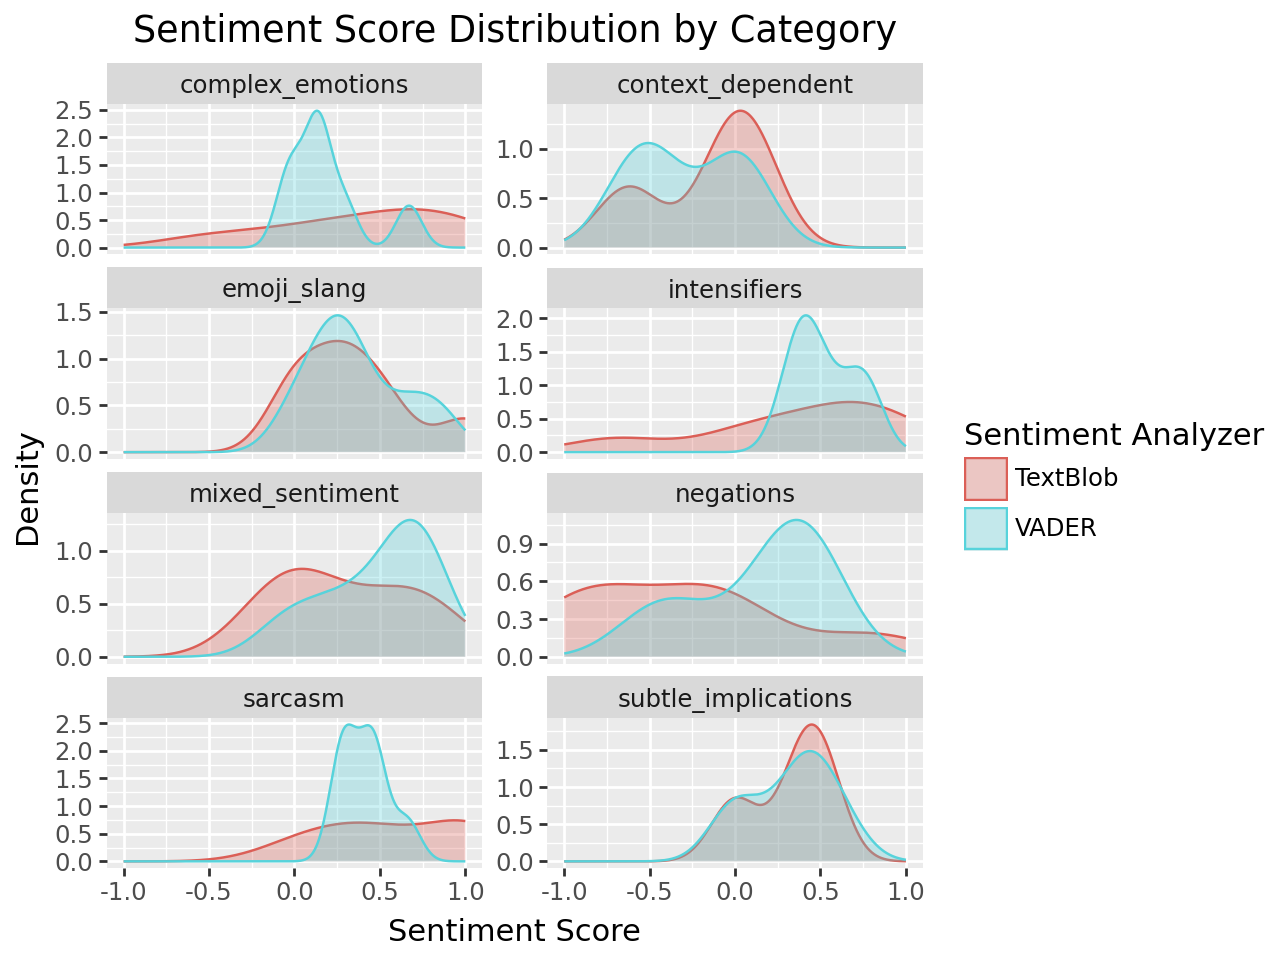

In [52]:
from plotnine import *
# Reshape data for plotnine using correct column names
plot_data = pd.melt(results_df,
                    id_vars=['Category'],
                    value_vars=['VADER Score', 'TextBlob Polarity'],
                    var_name='scorer',
                    value_name='sentiment')

# Clean up the scorer names for legend
plot_data['scorer'] = plot_data['scorer'].map({
    'VADER Score': 'VADER',
    'TextBlob Polarity': 'TextBlob'
})

# Create the plot
(ggplot(plot_data, aes(x='sentiment',
                       fill='scorer',
                       color='scorer')) +
 geom_density(alpha=0.3) +
 facet_wrap('~ Category', scales='free_y', ncol=2) +
 labs(x='Sentiment Score',
      y='Density',
      title='Sentiment Score Distribution by Category',
      fill='Sentiment Analyzer',
      color='Sentiment Analyzer') +
 scale_x_continuous(limits=[-1, 1]))

So it is not totally a good idea to compare differences or means directly.

But we can use our understanding of how each score "behaves" (differs from the mean) to make a more fair comparison

First, we can calculate **standard deviation** -- an estimate of how variable is each of our polarity scores

In [60]:
print(results_df[['VADER Score', 'TextBlob Polarity']].std())
print(results_df[['VADER Score', 'TextBlob Polarity']].mean())

VADER Score          0.353300
TextBlob Polarity    0.506204
dtype: float64
VADER Score          0.269834
TextBlob Polarity    0.233068
dtype: float64


Now I can recalculate my original polarity into "how far the polarity is from mean, estimated in 'typical differences' (standard deviations). Stats people call this z-scores

In [53]:
from scipy import stats
results_df['VADER_zscore'] = stats.zscore(results_df['VADER Score'])
results_df['TextBlob_zscore'] = stats.zscore(results_df['TextBlob Polarity'])

(reminder you don't need to understand this code)

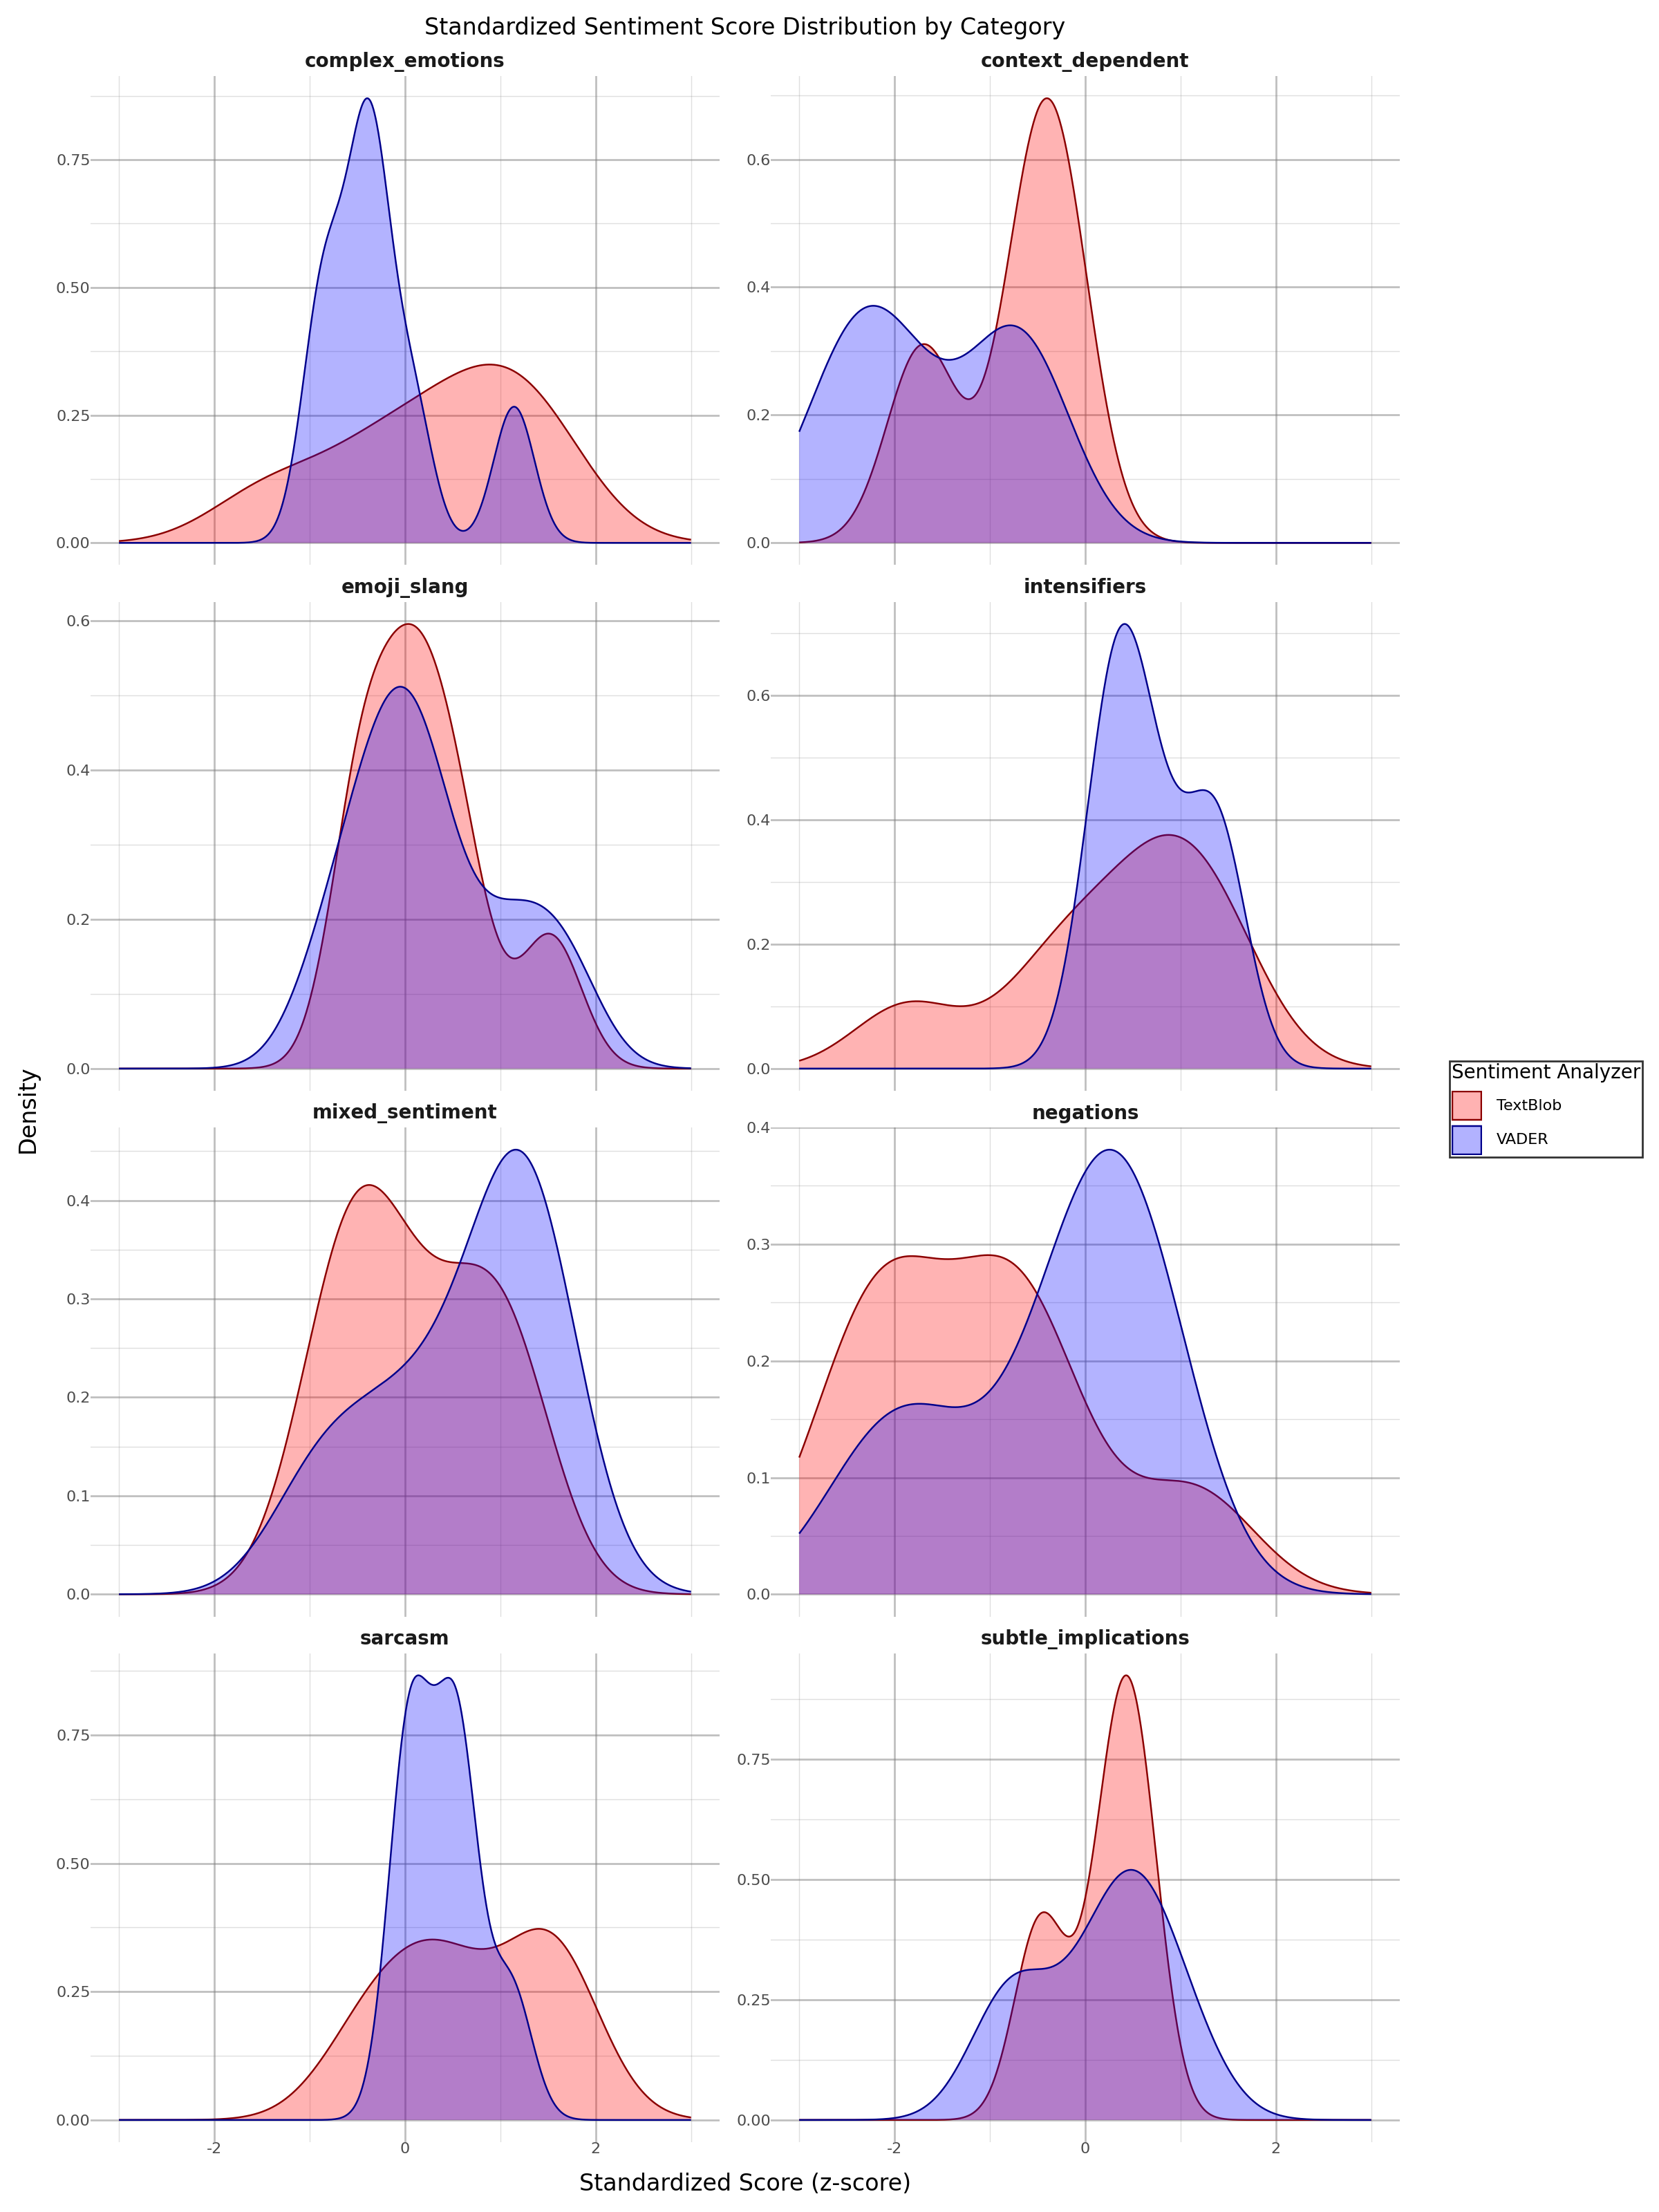

In [116]:
plot_data = pd.melt(results_df,
                    id_vars=['Category'],
                    value_vars=['VADER_zscore', 'TextBlob_zscore'],
                    var_name='scorer',
                    value_name='z_score')

# Clean up the scorer names for legend
plot_data['scorer'] = plot_data['scorer'].map({
    'VADER_zscore': 'VADER',
    'TextBlob_zscore': 'TextBlob'
})

# Create the plot
(ggplot(plot_data, aes(x='z_score',
                       fill='scorer',
                       color='scorer')) +
 geom_density(alpha=0.3) +
 facet_wrap('~ Category', scales='free_y', ncol=2) +
 theme_minimal() +
 scale_fill_manual(values=['red', 'blue']) +
 scale_color_manual(values=['darkred', 'darkblue']) +
 labs(x='Standardized Score (z-score)',
      y='Density',
      title='Standardized Sentiment Score Distribution by Category',
      fill='Sentiment Analyzer',
      color='Sentiment Analyzer') +
 theme(figure_size=(12, 2*len(results_df['Category'].unique())),
       axis_text=element_text(size=8),
       strip_text=element_text(size=10, face='bold'),
       title=element_text(size=12),
       legend_title=element_text(size=10),
       legend_text=element_text(size=8),
       legend_background=element_rect(fill='white', alpha=0.8),
       legend_box_margin=0,
       legend_position='right',
       panel_grid_major=element_line(color='grey', alpha=0.5),
       panel_grid_minor=element_line(color='grey', alpha=0.25)) +
 scale_x_continuous(limits=[-3, 3]))  # typical range for z-scores

# Getting started with Plotting Sentiment

First, let's import our libraries, set our Pandas display options, and reload the data produced during last week's lecture (handily stored in a CSV that lives in the same folder as this notebook).

## Rolling Averages in Pandas

Pandas is basically built to do things like calculate rolling averages. It makes it really easy, which is awesome. All we need to do is specify:
- What part of the DataFrame we're interested in (here, the `polarity` column)
- That we want to do a rolling... something or other (the `.rolling()` method)... and that we want our rolling window size to be (here it's 10, indicated with the `window=10` agument) and that we want these rolling averages to be "centred" — which you'll understand if you were in lecture 😊 and which is explained in Mary's lecture (the `centred=True` argument)
- That the "something or other" we want are rolling **averages (or means)** (indicated with the `.mean()` method)

In [ ]:
import pandas as pd
from textblob import TextBlob

In [ ]:
pd.set_option('display.max_colwidth', 0)

In [ ]:
sot4_sentence_sentiment_df = pd.read_csv("sot4_sentence_sentiment.csv")
sot4_sentence_sentiment_df[:15]

,sentence,polarity,subjectivity
0,Chapter I The Science of Deduction Sherlock Holmes took his bottle from the corner of the mantel-piece and his hypodermic syringe from its neat morocco case,0.000000,0.000000
1,With his long white nervous fingers he adjusted the delicate needle and rolled back his left shirt-cuff,-0.070000,0.260000
2,For some little time his eyes rested thoughtfully upon the sinewy forearm and wrist all dotted and scarred with innumerable puncture-marks,0.106250,0.500000
3,Finally he thrust the sharp point home pressed down the tiny piston and sank back into the velvet-lined arm-chair with a long sigh of satisfaction,-0.055093,0.489815
4,Three times a day for many months I had witnessed this performance but custom had not reconciled my mind to it,0.500000,0.500000
5,On the contrary from day to day I had become more irritable at the sight and my conscience swelled nightly within me at the thought that I had lacked the courage to protest,0.500000,0.500000
6,Again and again I had registered a vow that I should deliver my soul upon the subject but there was that in the cool nonchalant air of my companion which made him the last man with whom one would care to take anything approaching to a liberty,0.045833,0.262500
7,His great powers his masterly manner and the experience which I had had of his many extraordinary qualities all made me diffident and backward in crossing him,0.358333,0.762500
8,Yet upon that afternoon whether it was the Beaune which I had taken with my lunch or the additional exasperation produced by the extreme deliberation of his manner I suddenly felt that I could hold out no longer,-0.062500,0.750000
9,“ Which is it to-day ” I asked — “ morphine or cocaine ” He raised his eyes languidly from the old black-letter volume which he had opened,0.100000,0.200000


Now let's run the command we ended last lecture with, plotting the "raw" sentiment polarity values for every sentence in *The Sign of the Four*. Can we learn much from this?

<Axes: >

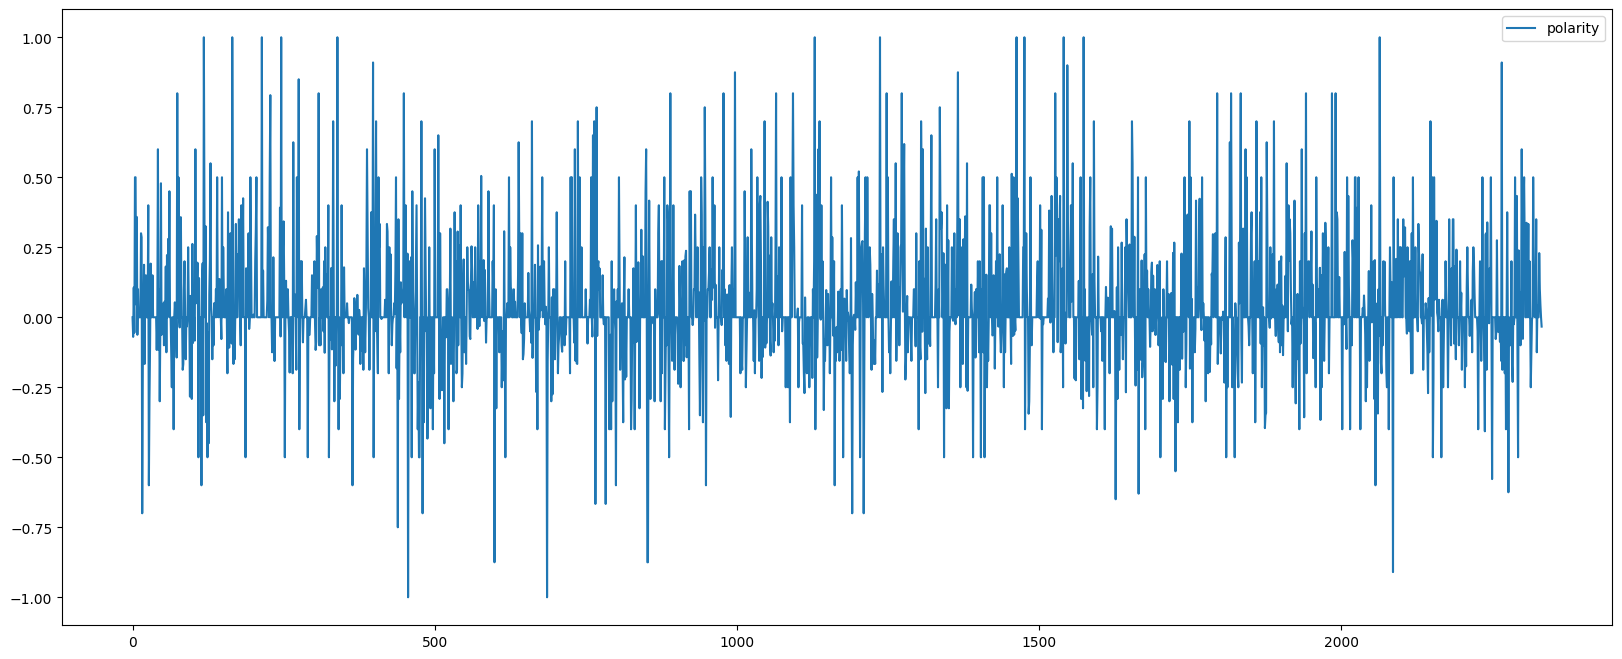

In [ ]:
sot4_sentence_sentiment_df[['polarity']].plot(figsize=(20,8))

Just for fun, let's have a look at the raw subjectivity scores, too...

<Axes: >

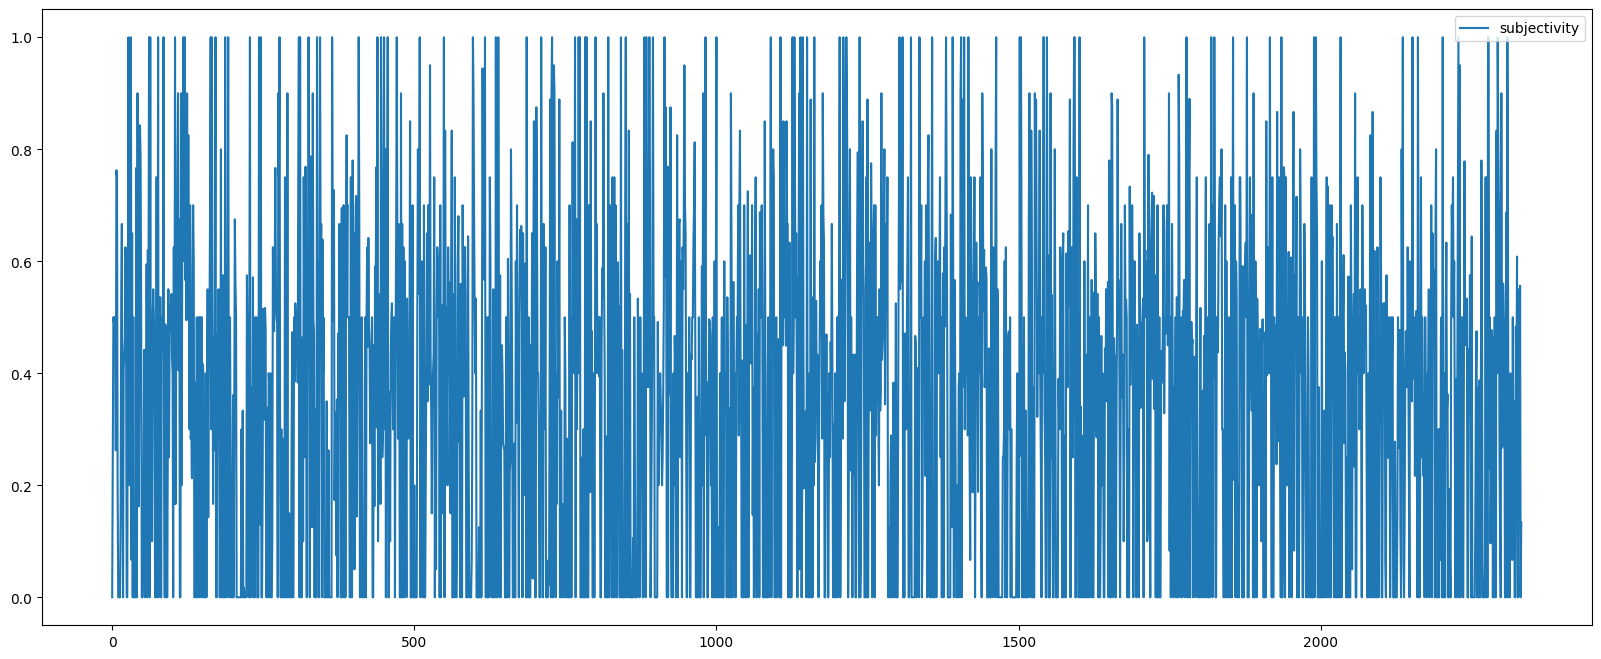

In [ ]:
sot4_sentence_sentiment_df[['subjectivity']].plot(figsize=(20,8))

### Now let's discuss one way to try to find a signal in this noisy data -- rolling averages

Pandas gives us a good way to calculate characteristics of our data in progress.

For example, if we would have a dataset of all your weekly grades (transformed to the same scale), we could try to find how were you doing every day... week... two weeks... month... of your studies by calculating **rolling mean** with different windows.

We don't hav to always use time, any consistent index of progress works -- sentence order in the book works as well!

In [113]:
sot4_sentence_sentiment_df['rolling_10_polarity'] = sot4_sentence_sentiment_df['polarity'].rolling(window=10, center=True).mean()

In [115]:
sot4_sentence_sentiment_df[:10][["sentence","polarity","rolling_10_polarity"]]

,sentence,polarity,rolling_10_polarity
0,Chapter I The Science of Deduction Sherlock Holmes took his bottle from the corner of the mantel-piece and his hypodermic syringe from its neat morocco case,0.000000,NaN
1,With his long white nervous fingers he adjusted the delicate needle and rolled back his left shirt-cuff,-0.070000,NaN
2,For some little time his eyes rested thoughtfully upon the sinewy forearm and wrist all dotted and scarred with innumerable puncture-marks,0.106250,NaN
3,Finally he thrust the sharp point home pressed down the tiny piston and sank back into the velvet-lined arm-chair with a long sigh of satisfaction,-0.055093,NaN
4,Three times a day for many months I had witnessed this performance but custom had not reconciled my mind to it,0.500000,NaN
5,On the contrary from day to day I had become more irritable at the sight and my conscience swelled nightly within me at the thought that I had lacked the courage to protest,0.500000,0.142282
6,Again and again I had registered a vow that I should deliver my soul upon the subject but there was that in the cool nonchalant air of my companion which made him the last man with whom one would care to take anything approaching to a liberty,0.045833,0.142282
7,His great powers his masterly manner and the experience which I had had of his many extraordinary qualities all made me diffident and backward in crossing him,0.358333,0.149282
8,Yet upon that afternoon whether it was the Beaune which I had taken with my lunch or the additional exasperation produced by the extreme deliberation of his manner I suddenly felt that I could hold out no longer,-0.062500,0.138657
9,“ Which is it to-day ” I asked — “ morphine or cocaine ” He raised his eyes languidly from the old black-letter volume which he had opened,0.100000,0.144167


Why the first value appears at row 5?
Because we need 10 rows centered around 5, so:

`[row0, row1, row2, row3, row4, (row5), row6, row7, row8, row9]`


Now all we need to do is to plot our new column!

Does that look any better?

<Axes: >

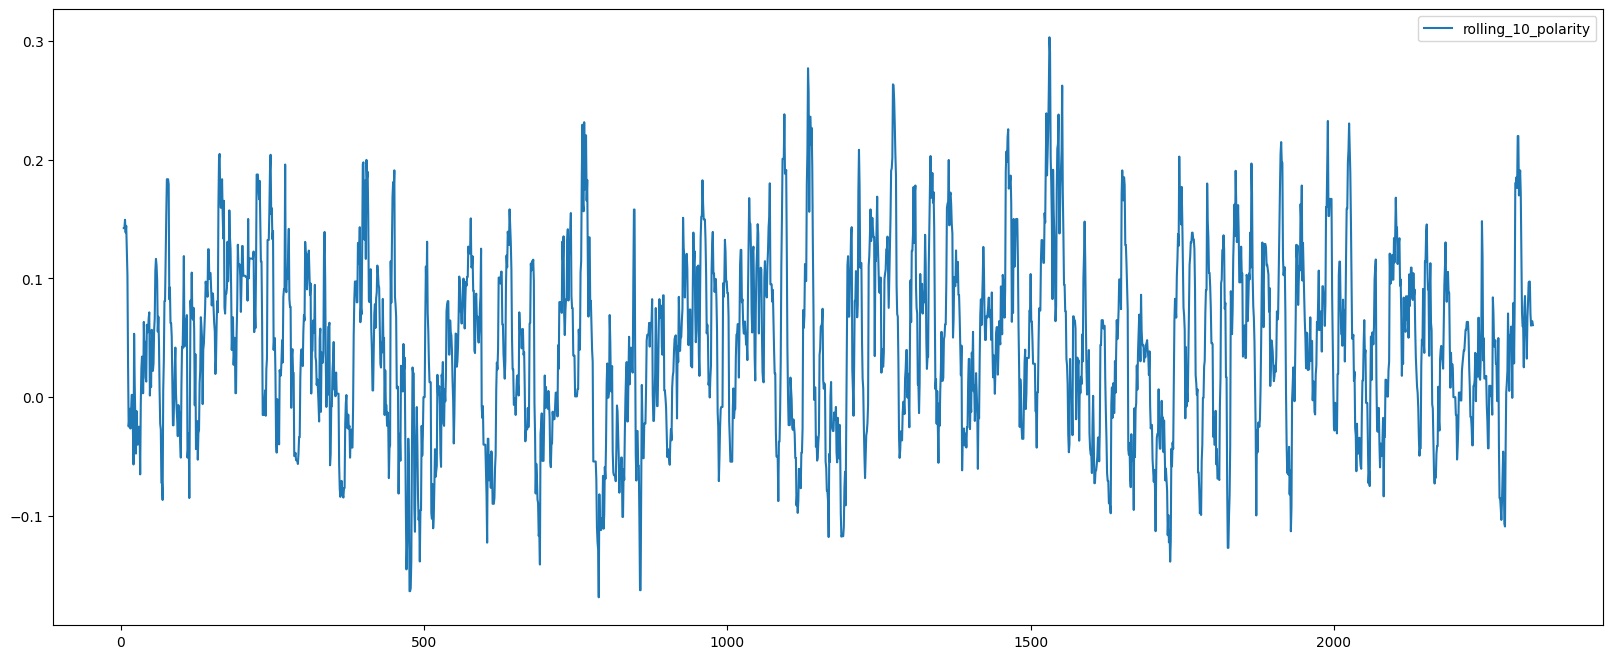

In [83]:
sot4_sentence_sentiment_df[['rolling_10_polarity']].plot(figsize=(20,8))

<Axes: >

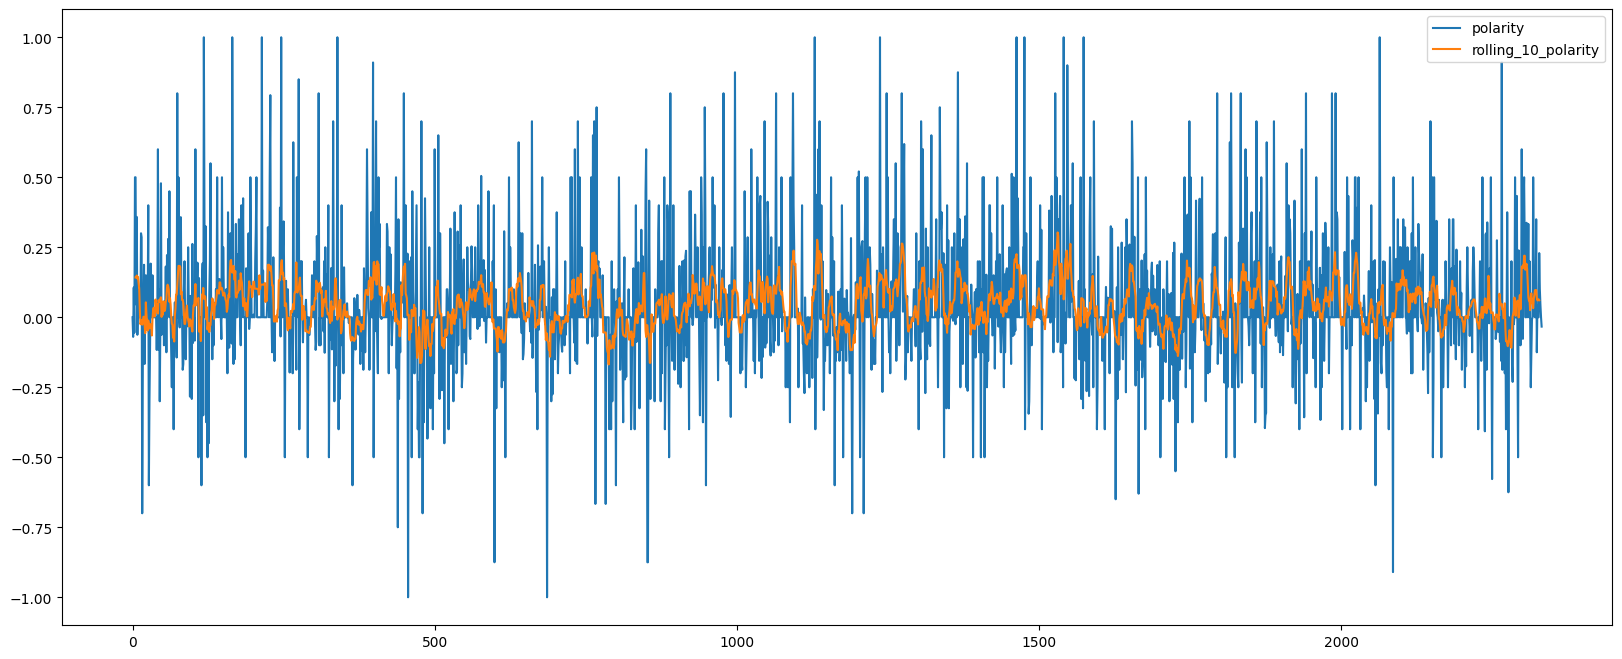

In [84]:
sot4_sentence_sentiment_df[['polarity','rolling_10_polarity']].plot(figsize=(20,8))

Let's try some other window sizes: e.g. 25. (You can try others, too!)

In [85]:
sot4_sentence_sentiment_df['rolling_25_polarity'] = sot4_sentence_sentiment_df['polarity'].rolling(window=25, center=True).mean()

<Axes: >

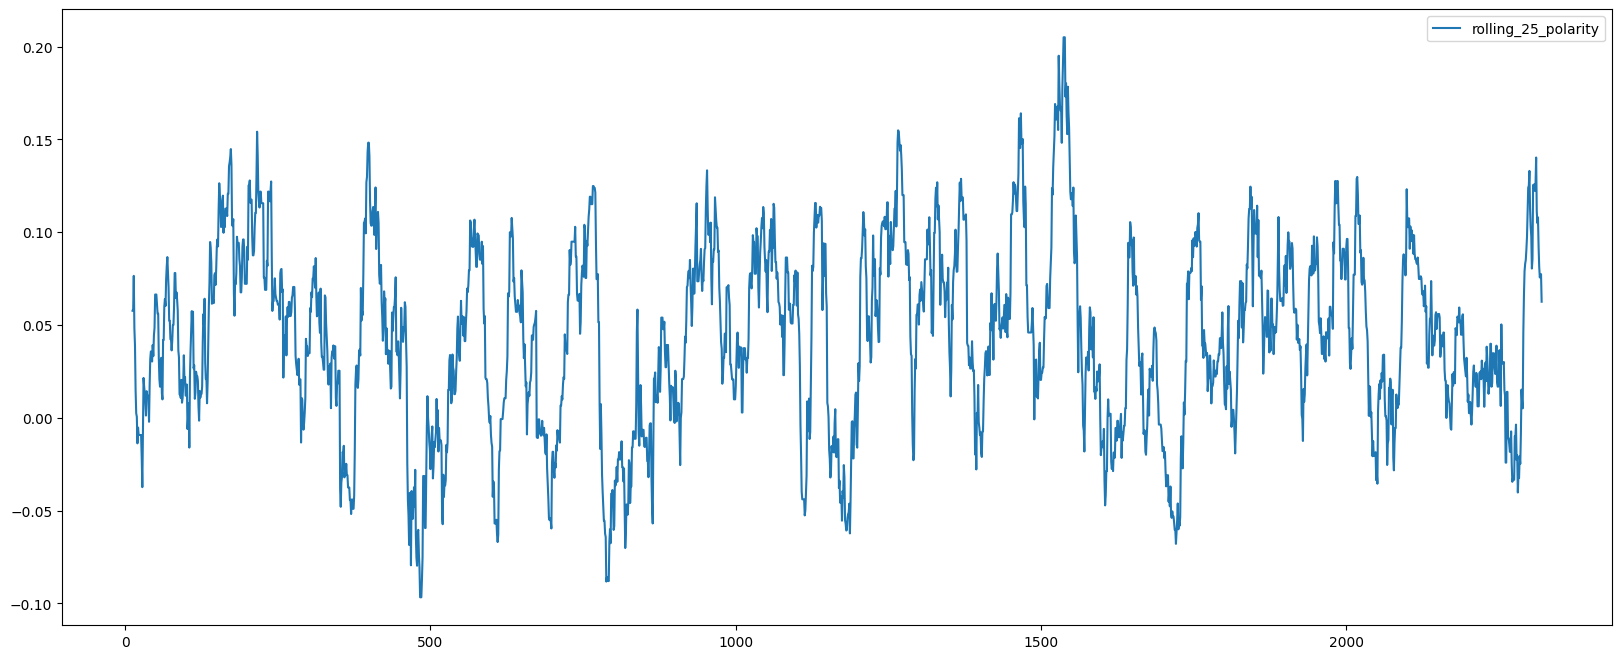

In [86]:
sot4_sentence_sentiment_df[['rolling_25_polarity']].plot(figsize=(20,8))

<Axes: >

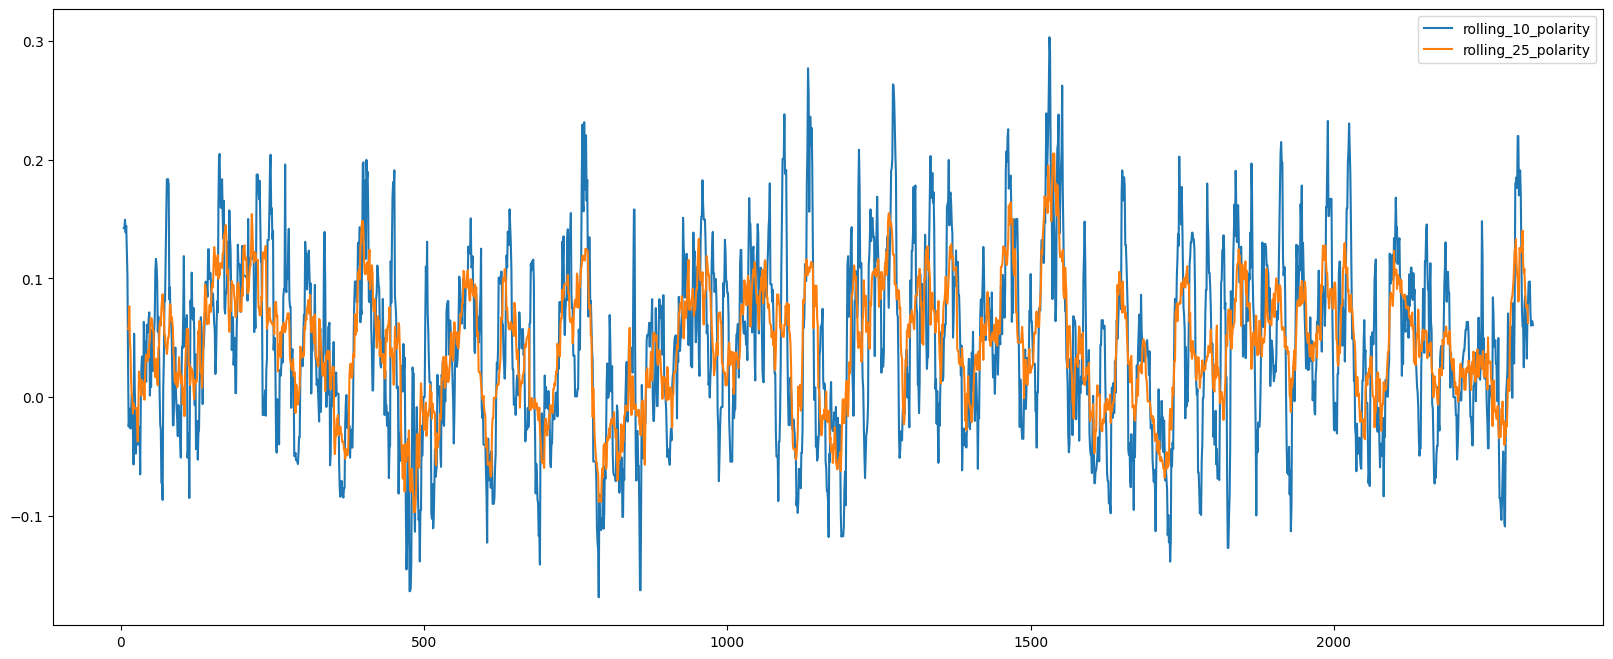

In [87]:
sot4_sentence_sentiment_df[['rolling_10_polarity','rolling_25_polarity']].plot(figsize=(20,8))

In [88]:
sot4_sentence_sentiment_df['rolling_50_polarity'] = sot4_sentence_sentiment_df['polarity'].rolling(window=50, center=True).mean()

<Axes: >

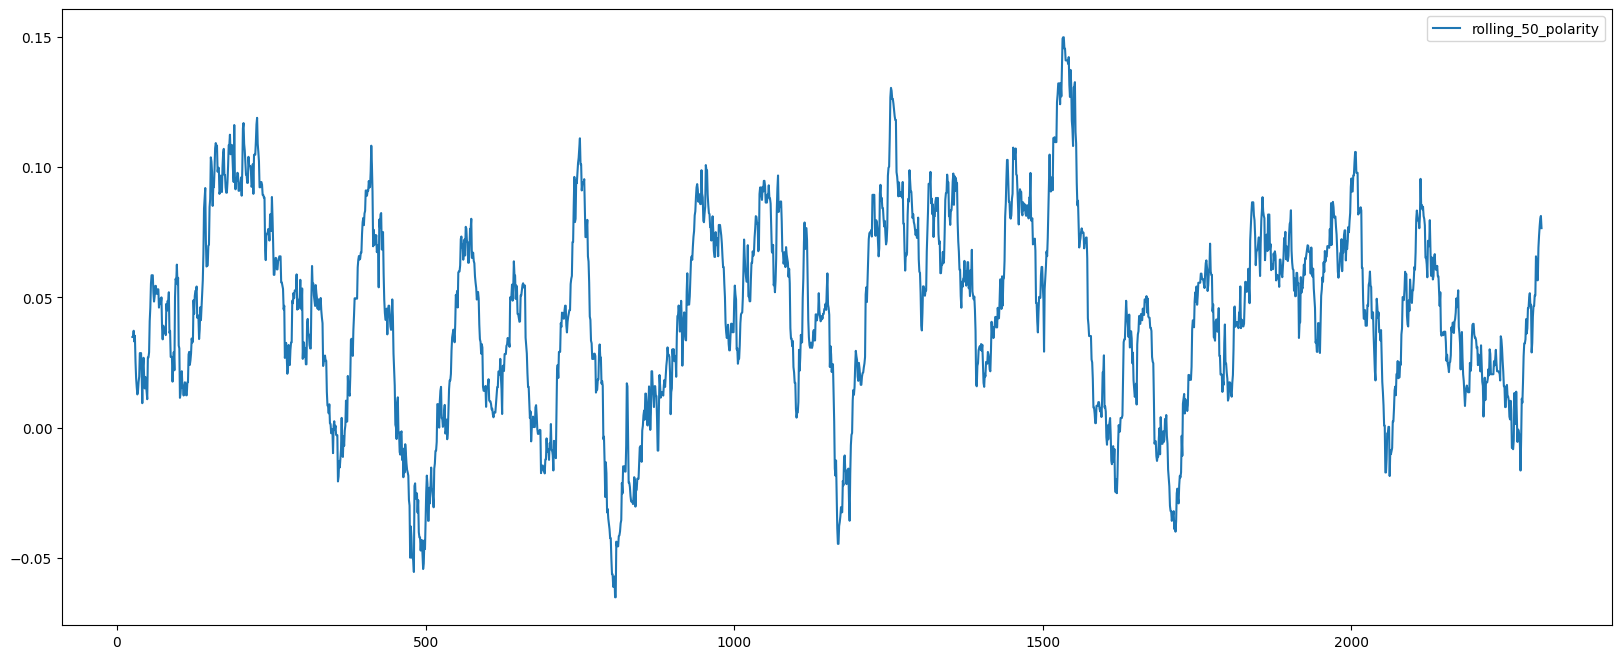

In [89]:
sot4_sentence_sentiment_df[['rolling_50_polarity']].plot(figsize=(20,8))

<Axes: >

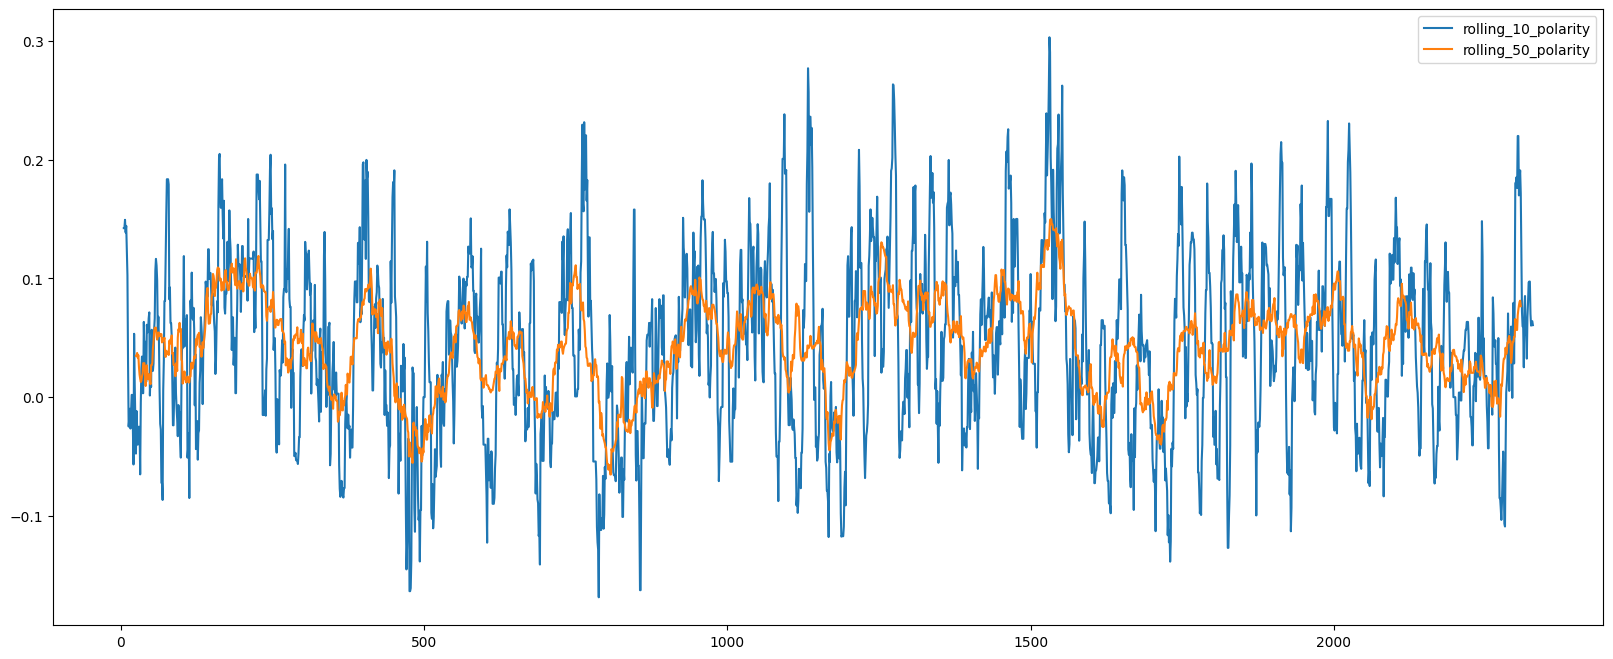

In [123]:
sot4_sentence_sentiment_df[['rolling_10_polarity','rolling_50_polarity']].plot(figsize=(20,8))

## Finding the Maximum and Minimum Points

The below line of Pandas code is an absolute whopper... but I think we're all ready for it at this point!

In [104]:
sot4_sentence_sentiment_df[sot4_sentence_sentiment_df['rolling_50_polarity']==sot4_sentence_sentiment_df['rolling_50_polarity'].min()]

,sentence,polarity,subjectivity,rolling_10_polarity,rolling_25_polarity,rolling_50_polarity,rolling_100_polarity
807,“ My dear Watson try a little analysis yourself ” said he with a touch of impatience,-0.1875,0.5,0.047222,-0.022454,-0.065088,0.002841
808,“ You know my methods,0.0000,0.0,0.009722,-0.022454,-0.065088,-0.000701


Step-by-step explanation

In [105]:
sot4_sentence_sentiment_df['rolling_50_polarity'].min()

-0.06508789682539683

In [100]:
min_polarity_50 = sot4_sentence_sentiment_df['rolling_50_polarity'].min()

In [101]:
sot4_sentence_sentiment_df['rolling_50_polarity'] == min_polarity_50

,rolling_50_polarity
0,False
1,False
2,False
3,False
4,False
...,...
2328,False
2329,False
2330,False
2331,False


In [102]:
has_min_polarity_50 = sot4_sentence_sentiment_df['rolling_50_polarity'] == min_polarity_50

In [103]:
sot4_sentence_sentiment_df[has_min_polarity_50]

,sentence,polarity,subjectivity,rolling_10_polarity,rolling_25_polarity,rolling_50_polarity,rolling_100_polarity
807,“ My dear Watson try a little analysis yourself ” said he with a touch of impatience,-0.1875,0.5,0.047222,-0.022454,-0.065088,0.002841
808,“ You know my methods,0.0000,0.0,0.009722,-0.022454,-0.065088,-0.000701


how about maximum for window 25?

In [110]:
sot4_sentence_sentiment_df['rolling_25_polarity'].max()

0.2050198412698413

In [111]:
sot4_sentence_sentiment_df[sot4_sentence_sentiment_df['rolling_25_polarity']==sot4_sentence_sentiment_df['rolling_25_polarity'].max()]

,sentence,polarity,subjectivity,rolling_10_polarity,rolling_25_polarity,rolling_50_polarity,rolling_100_polarity
1537,I should much like to have a few details about this matter from the lips of Jonathan Small himself,-0.083333,0.233333,0.191429,0.20502,0.14091,0.083701
1538,You know I like to work the detail of my cases out,0.000000,0.000000,0.156429,0.20502,0.14091,0.083535
1539,There is no objection to my having an unofficial interview with him either here in my rooms or elsewhere as long as he is efficiently guarded ” “ Well you are master of the situation,0.175000,0.500000,0.138095,0.20502,0.14091,0.083910


## Investigating the Extremes

Let's have a look at the 25-sentence window that the `rolling_25_polarity` score indicates are the most most positive, and see if seems like it's on to something...

(Yeah, that's right, I'm just taking the min and max points, then manually adding and subtracting 12 or 13 to make a 25-ish-sentence window!)

In [140]:
sot4_sentence_sentiment_df[sot4_sentence_sentiment_df['rolling_25_polarity']==sot4_sentence_sentiment_df['rolling_25_polarity'].max()]

,sentence,polarity,subjectivity,rolling_10_polarity,rolling_25_polarity,rolling_50_polarity,rolling_100_polarity
1537,I should much like to have a few details about this matter from the lips of Jonathan Small himself,-0.083333,0.233333,0.191429,0.20502,0.14091,0.083701
1538,You know I like to work the detail of my cases out,0.000000,0.000000,0.156429,0.20502,0.14091,0.083535
1539,There is no objection to my having an unofficial interview with him either here in my rooms or elsewhere as long as he is efficiently guarded ” “ Well you are master of the situation,0.175000,0.500000,0.138095,0.20502,0.14091,0.083910


In [141]:
print(1538 - 13)
print(1538 + 13)

1525
1551


In [142]:
sot4_sentence_sentiment_df[1525:1551].head() #remove head to see all of it, maybe transfor texts to list

,sentence,polarity,subjectivity,rolling_10_polarity,rolling_25_polarity,rolling_50_polarity,rolling_100_polarity
1525,We shall give you two others in the place of them,0.000000,0.000000,0.198917,0.160749,0.132085,0.092361
1526,But you must put yourself under my orders,0.000000,0.000000,0.238917,0.160749,0.132085,0.089861
1527,You are welcome to all the official credit but you must act on the line that I point out,0.800000,0.900000,0.186694,0.167749,0.132085,0.080861
1528,Is that agreed ” “ Entirely if you will help me to the men ” “ Well then in the first place I shall want a fast police-boat—a steam launch—to be at the Westminster Stairs at seven o ’ clock ” “ That is easily managed,0.220833,0.597917,0.205694,0.155083,0.124085,0.083305
1529,There is always one about there but I can step across the road and telephone to make sure ” “ Then I shall want two stanch men in case of resistance ” “ There will be two or three in the boat,0.500000,0.888889,0.225694,0.195083,0.132210,0.083305


<Axes: >

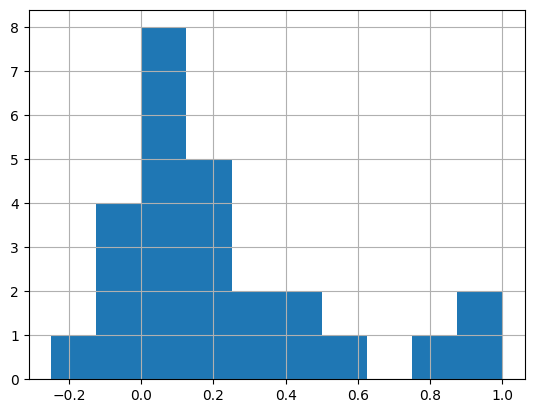

In [143]:
sot4_sentence_sentiment_df[1525:1551]["polarity"].hist()

What about the most negative?

In [144]:
sot4_sentence_sentiment_df[sot4_sentence_sentiment_df['rolling_25_polarity']==sot4_sentence_sentiment_df['rolling_25_polarity'].min()]

,sentence,polarity,subjectivity,rolling_10_polarity,rolling_25_polarity,rolling_50_polarity,rolling_100_polarity
483,I alone knew it,0.000,0.0,0.020000,-0.096667,-0.021381,-0.016085
484,When in India he and I through a remarkable chain of circumstances came into possession of a considerable treasure,0.425,0.6,-0.093333,-0.096667,-0.027214,-0.012835
485,I brought it over to England and on the night of Morstan ’ s arrival he came straight over here to claim his share,0.200,0.4,-0.113333,-0.096667,-0.025214,-0.012960


In [145]:
print(484 - 13)
print(484 + 13)

471
497


<Axes: >

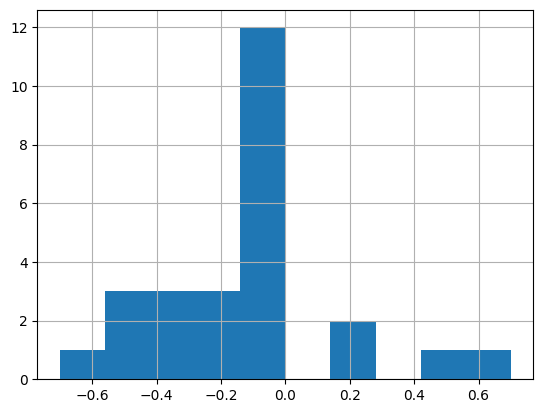

In [146]:
sot4_sentence_sentiment_df[471:497]["polarity"].hist()

Let's plot side by side

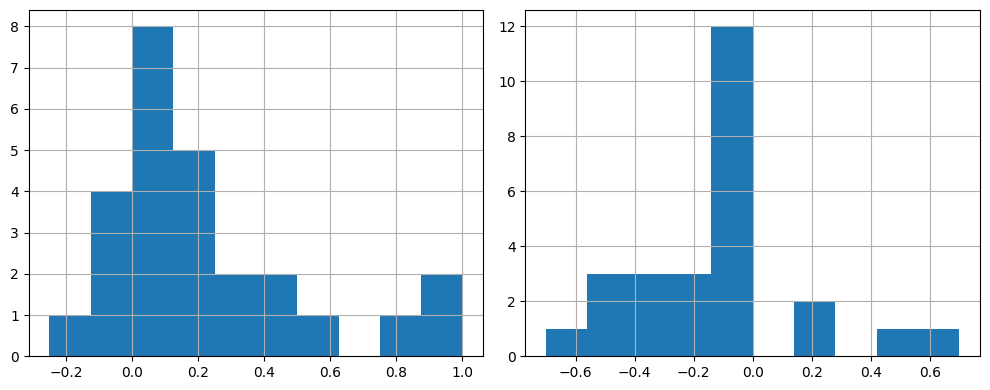

In [149]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sot4_sentence_sentiment_df[1525:1551]["polarity"].hist(ax=ax1)
sot4_sentence_sentiment_df[471:497]["polarity"].hist(ax=ax2)

plt.tight_layout()
plt.show()